In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools as it
import pydataset
import sklearn.preprocessing

TODO:

- find a dataset with features with different scales

Questions:

- reasonable to work with entire dataset in acquisition and prep
    - only to look at one variable at a time, not interactions
    - nulls, outliers, invalid data
- in theory, only explore the training data
- When to scale based on train vs entire dataset?
    - if you're not modeling, it doesn't matter
- Reasons to scale:
    - exploration
        - visualization of two variables on different scales
        - when a stat test assumes normality
    - modeling
        - anytime euclidean distance is used
        - when normality is assumed
        - improves convergance speed of gradient-descent optimization problems
        - multiple linear regression regularization penalizes higher coefficients, which could arise due to feature units
    - combining features of different scales
    - weight of unit magnitude
- is it reasonable to apply a transformation to a normal distribution and then, e.g., t-test the transformed data?
- Which scaler to use? all things being equal, choose the most simple
    - outliers - preserve
    - linear: minmax: easy to see values outside of 0-1
    - non-linear: box-cox the most popular
- How to interpret scaled coefficients? inv transform the coefficient
- scale the target? no (sometimes)

> In regression, it is often recommended to center the variables so that the predictors have mean 0. This makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation.
>
> -- [Marco on statsexchange](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)

1. Train Test Split

    Scaling params found from train, applied to test.

2. Scaling - when, where, what, why, and how

    - why
        - visualize the combination of 2 variables with different scales
        - stats tests that assume normality
        - improves most model's implementation
        - a better interpretation of the data (e.g. log scaling)
        - combining features
    - when
        - data prep / exploration
        - when one of the conditions above is met. Otherwise, it's better to work with the original units
    - where
        - the training dataset
        - usually just the independent variables
    - how:
        - sklearn.preprocessing -- requires 2d array
        - make the thing, fit the thing, use the thing
        - `.fit` to learn parameters, `.transform` to apply the scaling
        - seperate scaled dataframes and/or columns
        
3. Linear Scaling

    - MinMax: everything between 0 and 1
        $$ x' = \frac{x - \text{max}(x)}{\text{max}(x) - \text{min}(x)} $$
    - Standard: a zscore, standard deviations from the mean, **center** + **scale**
        $$ x' = \frac{x - \bar{x}}{s_x} $$
    - Robust: robust to and preserves outliers
        $$ x' = \frac{x - \text{med}(x)}{\text{IQR}_x} $$
        
4. Non-linear Scaling

    - Power Transform: choose $\lambda$ (-5 to 5) s.t. the standard deviation of the resulting distribution is the smallest

        Yeo-Johnson

        $$
        \begin{split}x_i^{(\lambda)} =
        \begin{cases}
         [(x_i + 1)^\lambda - 1] / \lambda & \text{if } \lambda \neq 0, x_i \geq 0, \\[8pt]
        \ln{(x_i) + 1} & \text{if } \lambda = 0, x_i \geq 0 \\[8pt]
        -[(-x_i + 1)^{2 - \lambda} - 1] / (2 - \lambda) & \text{if } \lambda \neq 2, x_i < 0, \\[8pt]
         - \ln (- x_i + 1) & \text{if } \lambda = 2, x_i < 0
        \end{cases}\end{split}
        $$

        Box-Cox (only positive data)

        $$
        \begin{split}x_i^{(\lambda)} =
        \begin{cases}
        \dfrac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\[8pt]
        \ln{(x_i)} & \text{if } \lambda = 0,
        \end{cases}\end{split}
        $$
    
    - Quantile: data points are "ranked", for a normal output, highest_orig -> highest_norm and then 2nd highest, etc
    
    - Log
    
        $$ x' = \log_b{x} $$
        
        $$ b^{x'} = x $$
        
        Sometimes you can just set the x/y scale w/ matplotlib

<div style="display: flex; text-align: center;">
    <div style="padding: 2em 0; border: 1px solid black; width: 80%">Train</div>
    <div style="padding: 2em 0; border: 1px solid black; width: 20%">Test</div>
</div>

In [2]:
scalers = [
    ('min-max', sklearn.preprocessing.MinMaxScaler()),
    ('standard (z-score)', sklearn.preprocessing.StandardScaler()),
    ('quantile (uniform)', sklearn.preprocessing.QuantileTransformer()),
    ('quantile (normal)', sklearn.preprocessing.QuantileTransformer(output_distribution='normal')),
    ('power', sklearn.preprocessing.PowerTransformer()),
    ('robust', sklearn.preprocessing.RobustScaler()),
]

In [3]:
df = pd.DataFrame(dict(original=[0, 1, 2, 3, 100]))

df.assign(**{
    name: lambda df: scaler.fit_transform(df[["original"]])
    for name, scaler in scalers
})

,original,min-max,standard (z-score),quantile (uniform),quantile (normal),power,robust
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
2,2,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.5,0.5,0.5,0.5,0.5,0.5
4,100,49.0,49.0,49.0,49.0,49.0,49.0


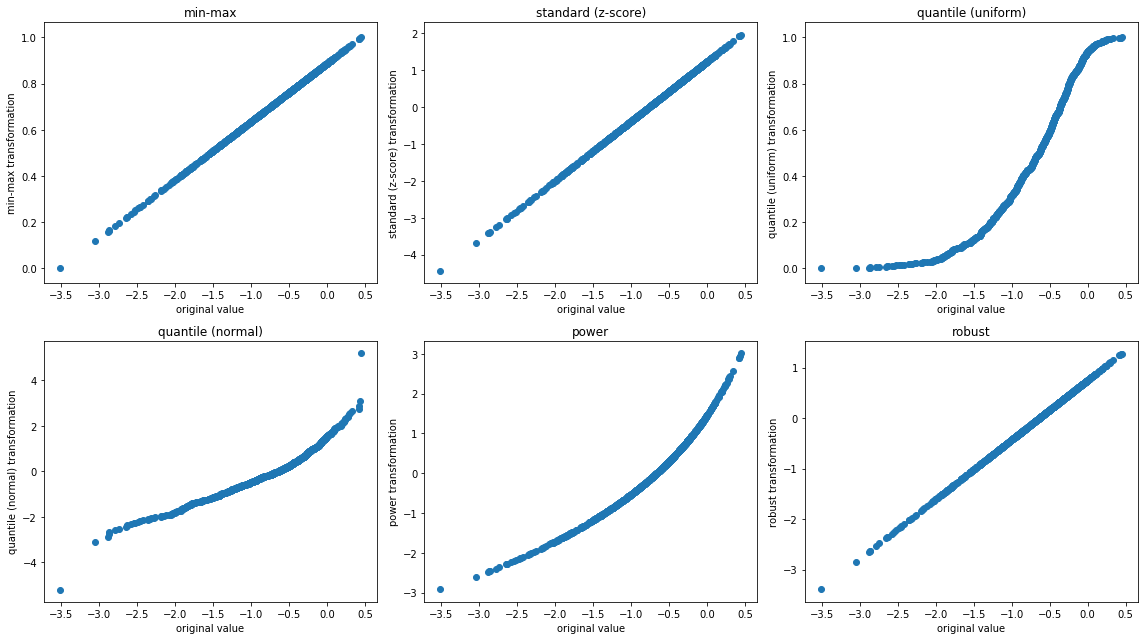

In [4]:
x = stats.skewnorm(-5).rvs(1000)
df = pd.DataFrame(dict(original=x))
                  
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

for (name, scaler), ax in zip(scalers, axs.ravel()):
    df[name] = scaler.fit_transform(df[['original']])
    ax.scatter(df.original, df[name])
    ax.set(title=name, xlabel='original value', ylabel=f'{name} transformation')

fig.tight_layout()

## Viz Scaling Demo

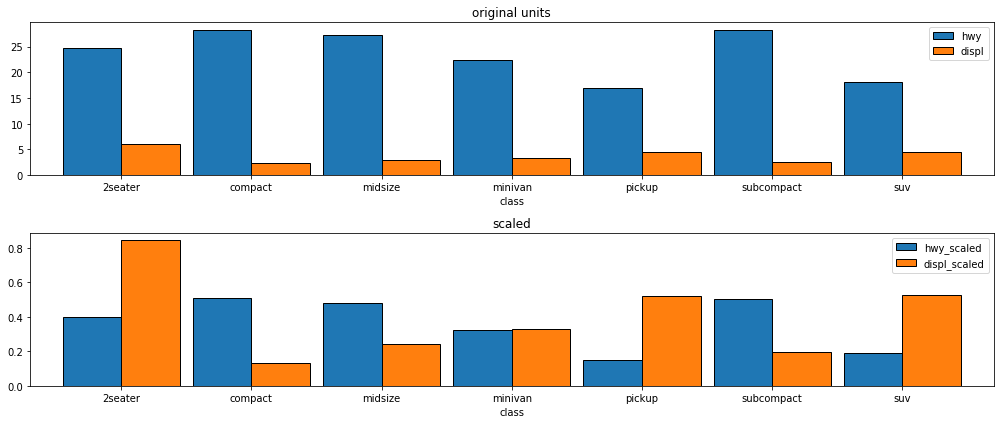

In [5]:
mpg = pydataset.data('mpg')

# scaler = sklearn.preprocessing.StandardScaler()
scaler = sklearn.preprocessing.MinMaxScaler()

mpg['hwy_scaled'] = scaler.fit_transform(mpg[['hwy']])
mpg['displ_scaled'] = scaler.fit_transform(mpg[['displ']])

plt.figure(figsize=(14, 6))

plt.subplot(211)
mpg[['hwy', 'displ', 'class']].groupby('class').mean().plot.bar(ax=plt.gca(), ec='black', width=.9)
plt.xticks(rotation=0)
plt.title('original units')

plt.subplot(212)
mpg[['hwy_scaled', 'displ_scaled', 'class']].groupby('class').mean().plot.bar(ax=plt.gca(), ec='black', width=.9)
plt.xticks(rotation=0)
plt.title('scaled')

plt.tight_layout()

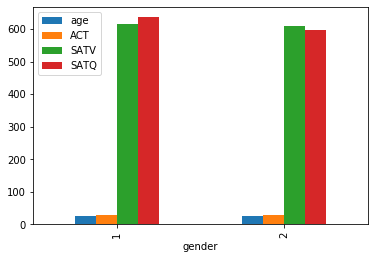

In [6]:
df = pydataset.data('sat.act')
df = df.drop(columns='education')
df.groupby('gender').mean().plot.bar()

In [7]:
scaler = sklearn.preprocessing.StandardScaler()
df_scaled = df.copy()

df_scaled['age'] = scaler.fit_transform(df[['age']])
df_scaled['ACT'] = scaler.fit_transform(df[['ACT']])
df_scaled['SATV'] = scaler.fit_transform(df[['SATV']])
df_scaled['SATQ'] = scaler.fit_transform(df[['SATQ']])

In [8]:
# # create a new dataframe with scaled columns with a for loop
# cols = ['age', 'ACT', 'SATV', 'SATQ']

# scaler = sklearn.preprocessing.StandardScaler()
# df_scaled = df.copy()

# for col in cols:
#     df_scaled[col] = scaler.fit_transform(df[[col]])

In [9]:
# # Add new _scaled columns to the original dataframe
# cols = ['age', 'ACT', 'SATV', 'SATQ']

# scaler = sklearn.preprocessing.StandardScaler()
# df_scaled = df.copy()

# for col in cols:
#     df[col + '_scaled'] = scaler.fit_transform(df[[col]])

In [10]:
# # create a new dataframe with scaled columns with a for loop
# cols = ['age', 'ACT', 'SATV', 'SATQ']

# scaler = sklearn.preprocessing.StandardScaler()
# df_scaled = df.copy()

# df_scaled[cols] = scaler.fit_transform(df[cols])

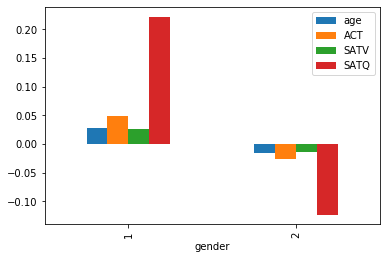

In [11]:
df_scaled.groupby('gender').mean().plot.bar()